In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
import os

In [16]:
# !unzip /content/drive/MyDrive/SAR/classification.zip -d /content/drive/MyDrive/SAR/

In [17]:
DATA_DIR = '/content/drive/MyDrive/SAR/v_2'
BATCH_SIZE = 32
EPOCHS = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [18]:
data = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)
data = data.map(lambda images, labels: (images/255, labels))

Found 16000 files belonging to 4 classes.


In [19]:
class_names = os.listdir(DATA_DIR)
n_classes = len(class_names)

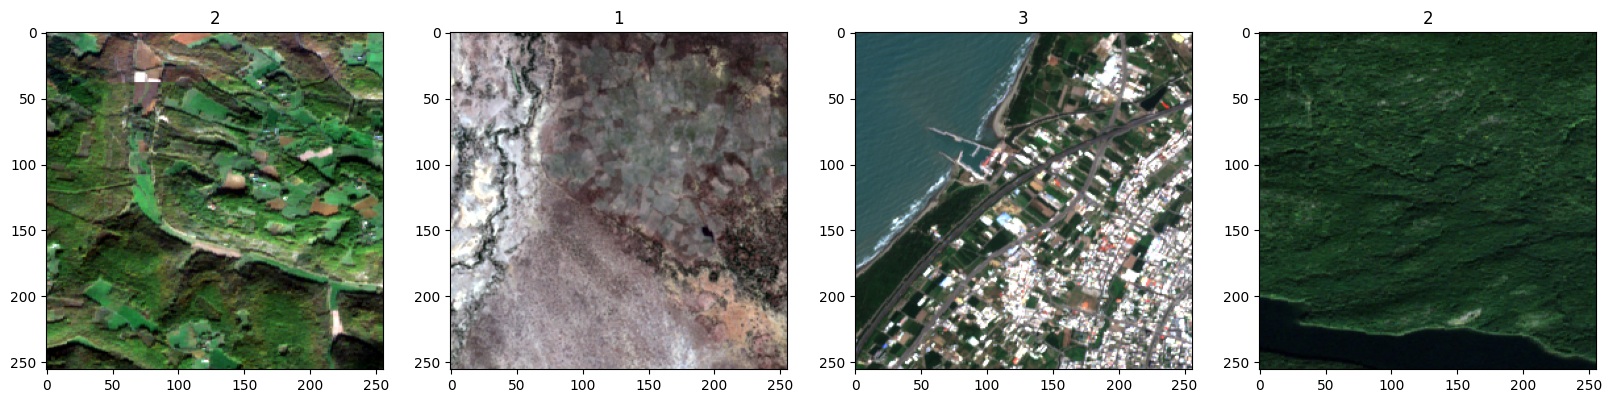

In [20]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [21]:
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

In [22]:
model = keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,413,028 (32.09 MB)

 Trainable params: 8,412,932 (32.09 MB)

 Non-trainable params: 96 (384.00 B)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
history = model.fit(
  train,
  validation_data=validation,
  epochs=EPOCHS,
  callbacks=[early_stopping],
)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1540s 4s/step - accuracy: 0.6617 - loss: 5.0105 - val_accuracy: 0.4124 - val_loss: 3.1192
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1469s 4s/step - accuracy: 0.8478 - loss: 0.9734 - val_accuracy: 0.9236 - val_loss: 0.6658
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1482s 4s/step - accuracy: 0.9226 - loss: 0.6568 - val_accuracy: 0.9524 - val_loss: 0.4940
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1416s 4s/step - accuracy: 0.9485 - loss: 0.4934 - val_accuracy: 0.8899 - val_loss: 0.7066
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1486s 4s/step - accuracy: 0.9440 - loss: 0.4579 - val_accuracy: 0.9428 - val_loss: 0.3942
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1500s 4s/step - accuracy: 0.9626 - loss: 0.3353 - val_accuracy: 0.9152 - val_loss: 0.4557


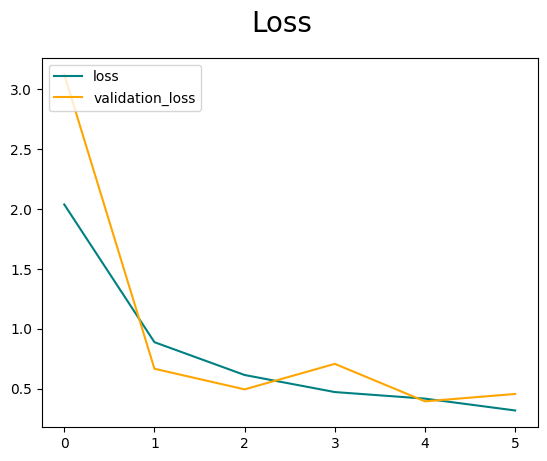

In [25]:
# loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

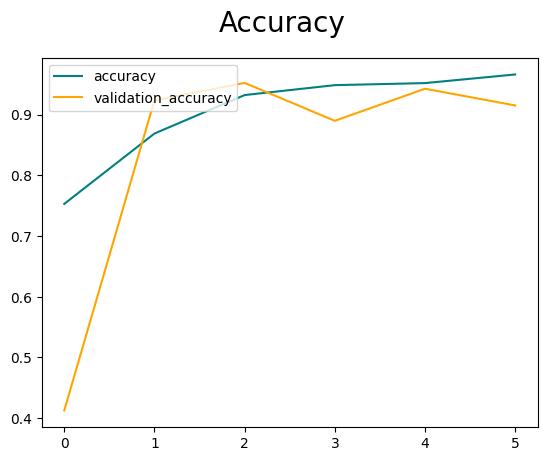

In [26]:
# accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'],
         color='orange', label='validation_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [27]:
model.evaluate(test, batch_size=BATCH_SIZE)

49/49 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9059 - loss: 0.4731


[0.46079686284065247, 0.9145408272743225]

In [28]:
model.save('/content/drive/MyDrive/SAR/classification.keras')